In [2]:
import numpy as np
import torch
from torch import nn
from torch.nn import init
# ライブラリ
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
import utils
import time

In [3]:
X = torch.randn(60, 30) 


for i in range(50):
    W = torch.randn(30, 30) * 0.01
    X = torch.mm(X, W.T) # 数字を上げていくと結果もさらに大きくなっていく

X

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Xavierの初期化を実装

In [27]:

X = torch.randn(60, 30)
n_in = 30
n_out = 30
std = torch.sqrt((torch.tensor(2./(n_in + n_out))))
for i in range(50):
    W = torch.randn(n_in, n_out) * std
    X = X @ W.T

print('mean', X.mean(), 'std', X.std())
X

mean tensor(-0.0182) std tensor(0.5501)


tensor([[ 1.7412, -0.0660,  0.2458,  ..., -2.1050, -0.3757, -1.3224],
        [ 1.1673, -0.0161,  0.4028,  ..., -1.1323, -0.1229, -0.8712],
        [ 0.6984, -0.0360, -0.1000,  ..., -1.0093, -0.2309, -0.5325],
        ...,
        [ 0.9118, -0.0025,  0.1970,  ..., -0.9201, -0.1436, -0.6416],
        [-0.0571,  0.0305,  0.2399,  ...,  0.3581,  0.1392,  0.0684],
        [ 0.4677, -0.0190, -0.0658,  ..., -0.6621, -0.1601, -0.3452]])

## Kaimingの初期化

In [24]:
X = torch.randn(60, 30)
n_in = 30
n_out = 30
std = torch.sqrt((torch.tensor(2./(n_in))))
for i in range(50):
    W = torch.randn(n_in, n_out) * std
    X = X @ W.T
    # 値が大きくなっているのでReLUの処理を入れてみる
    X = torch.clamp(X, min=0)

print('mean', X.mean(), 'std', X.std())
X

mean tensor(0.2076) std tensor(0.3997)


tensor([[1.2675, 0.0000, 0.0000,  ..., 0.0000, 0.3047, 0.0000],
        [0.4720, 0.0000, 0.0000,  ..., 0.0000, 0.1135, 0.0000],
        [1.4888, 0.0000, 0.0000,  ..., 0.0000, 0.3598, 0.0000],
        ...,
        [0.6336, 0.0000, 0.0000,  ..., 0.0000, 0.1516, 0.0000],
        [0.8849, 0.0000, 0.0000,  ..., 0.0000, 0.2115, 0.0000],
        [0.9635, 0.0000, 0.0000,  ..., 0.0000, 0.2347, 0.0000]])

## PytorchでKaiming初期化を実装

In [28]:
from torch.nn import init

In [43]:
# 簡易的なモデル
conv = nn.Conv2d(1, 8, kernel_size=3,stride=2, padding=1)
print('weight mean', conv.weight.mean().item(), 'weight std', conv.weight.std().item()) # default std = np.sqrt(1/3*n_in*k*k)
init.kaiming_normal_(conv.weight)
print('kaiming初期化後の', 'weight mean', conv.weight.mean().item(), 'weight std', conv.weight.std().item())

weight mean -0.010588470846414566 weight std 0.1963670700788498
kaiming初期化後の weight mean -0.042647480964660645 weight std 0.441699743270874


0.19245008972987526

## Batch normとLayer Normalization

In [1]:


class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [4]:
# model
# batchnormを適用したmodel
def get_gap_conv_model():
    return nn.Sequential(
    # 1x28x28 
    nn.Conv2d(1,4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),

    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),

    # 8x7x7
    nn.Conv2d(8,16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    # 16x4x4
    nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # 32x2x2
    # nn.Flatten() <- GAP -> 32x1x1
    nn.AdaptiveAvgPool2d(1),
    # 32xx1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10) 
)
conv_model = get_gap_conv_model()

In [8]:
# kaiming初期化
for layer in conv_model:
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight)

In [9]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),
])



train_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fminist_data', train = False, download=True, transform=transform)

# dataloader 
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 1024, num_workers=4)

opt = optim.SGD(conv_model.parameters(), lr=0.6)

In [10]:
act_stats = utils.ActivationStatistics(conv_model)

In [13]:
train_losses, val_losses, val_accuracy = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.8807385382005724, validation error: 0.5899283945560455, validation accuracy: 0.7878328263759613


epoch: 1: train error: 0.523163298934193, validation error: 0.5294104009866715, validation accuracy: 0.8022161960601807


epoch: 2: train error: 0.45497313798484157, validation error: 0.48543686866760255, validation accuracy: 0.8220244765281677


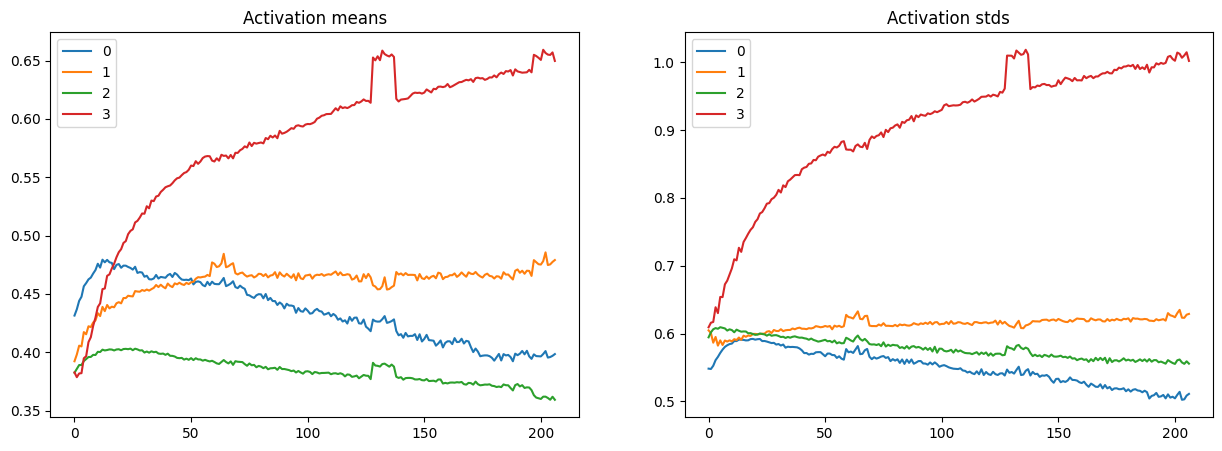

In [14]:
act_stats.plot_statistics()